# Regression with dropout uncertainty

In this notebook I train a feed forward NN to approximate a function and estimate uncertainty by sampling the dropout of the network.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

In [16]:
NUM_DATAPOINTS = 1000
RANDOM_SEED = 100
NUM_EPOCHS = 1500
BATCH_SIZE=128
DATA_SIGMA = 3
NOISE_SIGMA = 0.1
DROPOUT_PARAMETER = 0.1

<h3>Available functions</h3>

In [17]:
quadratic = lambda x: 15*(x**2) + 12*x + 2
cubic = lambda x: 2*(x**3) + 6*(x**2) - 90*x + 4
from numpy import sin
from scipy.signal import sawtooth

In [ ]:
function = sawtooth
#Filename should match function:
FILENAME = 'sawtooth.png'

In [18]:
X = DATA_SIGMA * np.random.randn(NUM_DATAPOINTS,1)
epsilon = NOISE_SIGMA * np.random.randn(NUM_DATAPOINTS,1)
y = [function(x) for x in X] + epsilon
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
df=pd.DataFrame({'x':X_test[:,0],'y':y_test[:,0]})

In [19]:
np.random.seed(RANDOM_SEED)
model = Sequential()
model.add(Dense(units=10, activation='relu', input_dim=1))
model.add(Dropout(DROPOUT_PARAMETER))
model.add(Dense(units=20, activation='relu'))
model.add(Dropout(DROPOUT_PARAMETER))
model.add(Dense(units=20, activation='relu'))
model.add(Dropout(DROPOUT_PARAMETER))
model.add(Dense(units=10, activation='relu'))
model.add(Dropout(DROPOUT_PARAMETER))
model.add(Dense(1))

In [20]:
model.compile(loss='mse',
        optimizer=RMSprop(),
        metrics=['mse'])

In [21]:
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, verbose=0,batch_size=BATCH_SIZE)
df['prediction'] = model.predict(X_test)
test_loss_and_metrics = model.evaluate(X_test, y_test)
train_loss_and_metrics = model.evaluate(X_train, y_train)

 32/800 [>.............................] - ETA: 0s

In [22]:
print("Final test loss: ",test_loss_and_metrics[1])
print("Final train loss: ",train_loss_and_metrics[1])

Final test loss:  0.0845593911409
Final train loss:  0.0527806228399


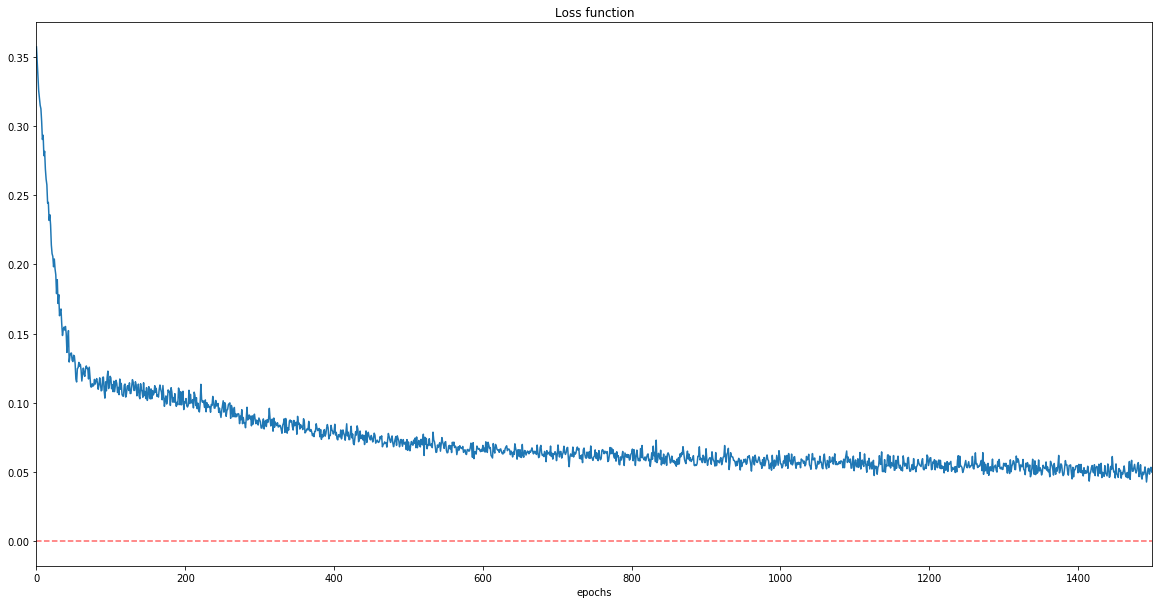

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.title("Loss function")
plt.xlabel("epochs")
plt.xlim(0,NUM_EPOCHS)
plt.axhline(y=0, ls='--',c='red',alpha=0.6)
plt.show()

In [24]:
import keras.backend as K
f = K.function([model.layers[0].input, K.learning_phase()],
        [model.layers[-1].output])

def predict_with_uncertainty(f, x, n_iter=100):
    result = np.zeros((n_iter,) + x.shape)
    for iter in range(n_iter):
        y = f([x,1])
        result[iter] = y
    prediction = result.mean(axis=0)
    uncertainty = result.var(axis=0) ** 0.5
    return prediction, uncertainty

In [25]:
df['mu'] = [predict_with_uncertainty(f, np.array([[x]]))[0][0][0] for x in df['x']]
df['sigma'] = [predict_with_uncertainty(f, np.array([[x]]))[1][0][0] for x in df['x']]
df['cred_int_lower'] = df['mu'] - (2*df['sigma'])
df['cred_int_upper'] = df['mu'] + (2*df['sigma'])
df = df.sort_values('x').reset_index(drop=True)

In [34]:
plt.figure(figsize=(20,10))
fig = plt.figure(figsize=(20,10))
plt.plot(df['x'],df['mu'], c='orange', ls='--')
plt.fill_between(df['x'],df['cred_int_lower'],df['cred_int_upper'], color='orange', alpha=0.3, label='95% credible interval')
plt.scatter(df['x'],df['y'])
plt.ylim(-2,2)
plt.xlim(-11,10)
plt.title("Learning a function with uncertainty")
plt.legend()
fig.savefig('images/' + FILENAME,dpi=96)

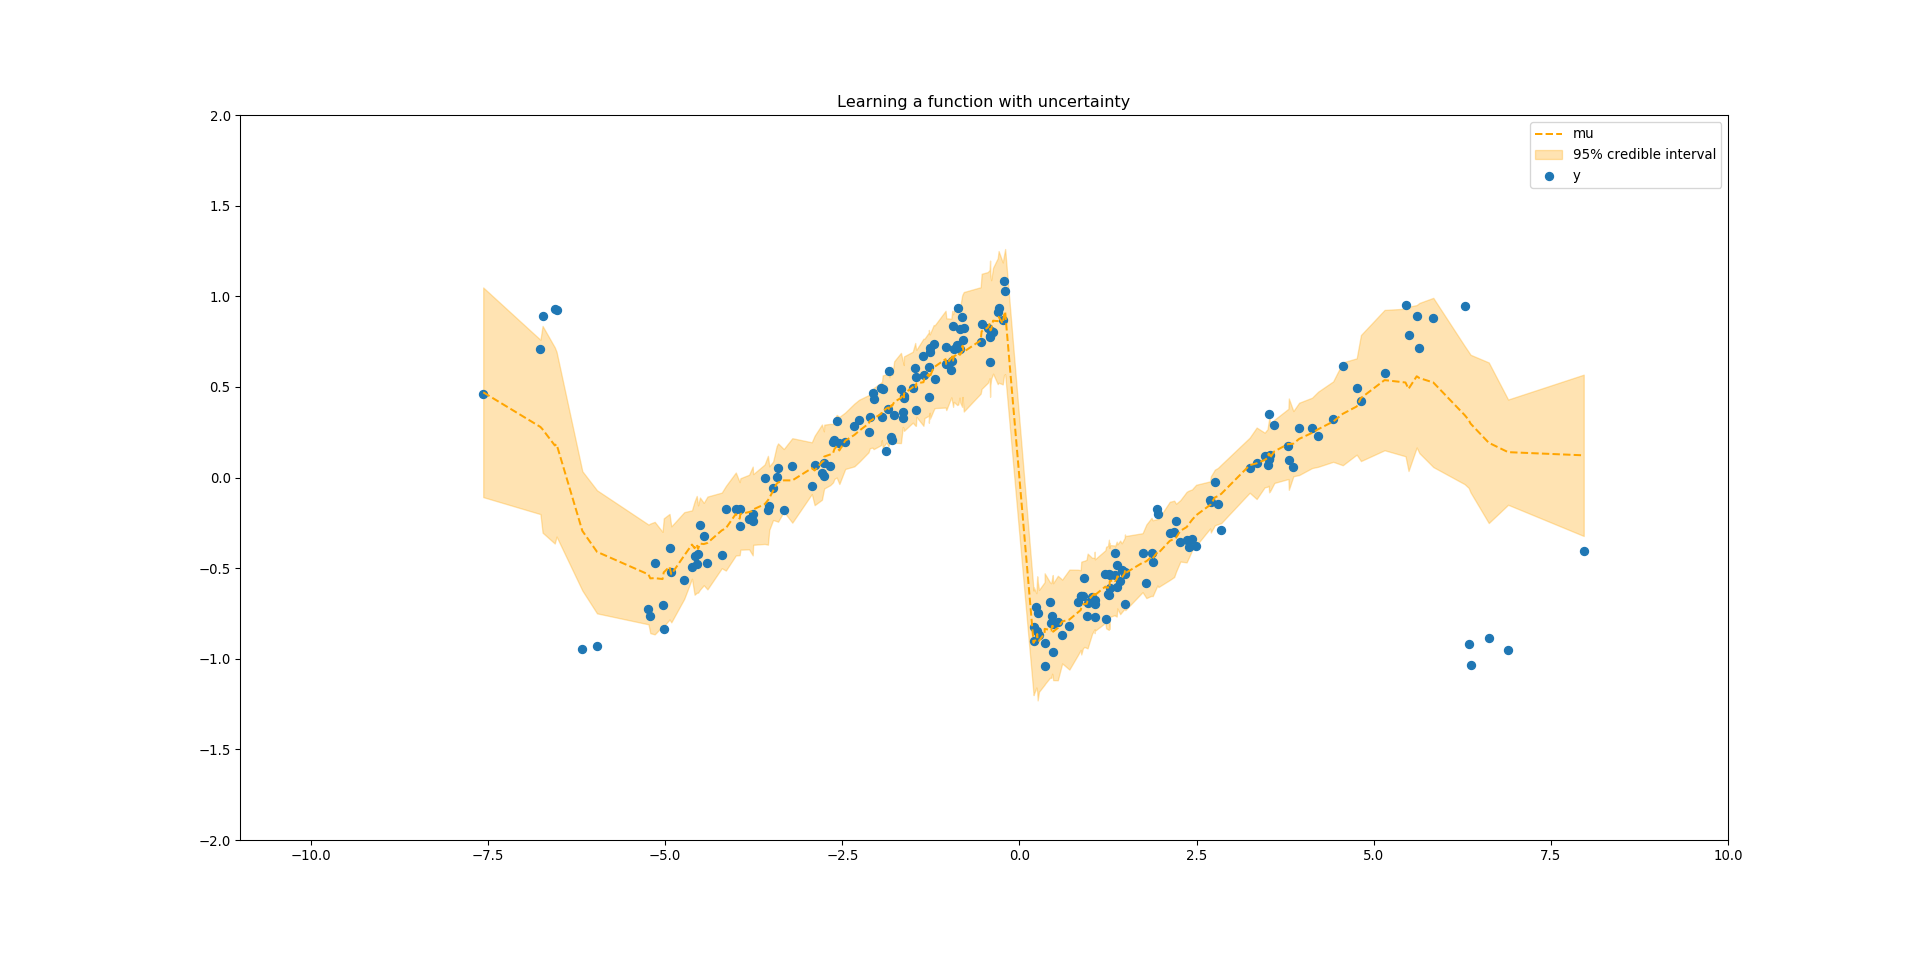

In [35]:
from IPython.display import Image
Image("images/" + FILENAME)